<h1>Visualizing data using python</h1>
<li><b>matplotlib</b>: basic python library for plots
<li><b>seaborn</b>: built on matplotlib. provides a high level interface for graphs
<li><b>geospatial maps</b>: interactive mapping. 
<li><b>highcharts</b>
<li><b>plot.ly</b>
<li><b>bokeh</b>

<h1>Data setup</h1>
<li>Use our function to read the data file</li>

In [1]:
def read_311_data(datafile):
    import pandas as pd
    import numpy as np
    
    #Add the fix_zip function
    def fix_zip(input_zip):
        try:
            input_zip = int(float(input_zip))
        except:
            try:
                input_zip = int(input_zip.split('-')[0])
            except:
                return np.NaN
        if input_zip < 10000 or input_zip > 19999:
            return np.NaN
        return str(input_zip)
    
    #Read the file
    df = pd.read_csv(datafile,index_col='Unique Key')
    
    #fix the zip
    df['Incident Zip'] = df['Incident Zip'].apply(fix_zip)
    
    #drop all rows that have any nans in them (note the easier syntax!)
    
    df = df.dropna(how='any')
    
    #get rid of unspecified boroughs
    df = df[df['Borough'] != 'Unspecified']
    
    #Convert times to datetime and create a processing time column
    
    import datetime
    df['Created Date'] = df['Created Date'].apply(lambda x:datetime.datetime.strptime(x,'%m/%d/%Y %I:%M:%S %p'))
    df['Closed Date'] = df['Closed Date'].apply(lambda x:datetime.datetime.strptime(x,'%m/%d/%Y %I:%M:%S %p'))
    df['processing_time'] =  df['Closed Date'] - df['Created Date']
    
    #Finally, get rid of negative processing times and return the final data frame
    
    df = df[df['processing_time']>=datetime.timedelta(0,0,0)]
    
    return df
    

In [2]:
datafile = "/Users/hardeepjohar/Documents/Courses/DataAnalyticsFall2017/DataVisualization/nyc_311_data_subset_small.csv"
df = read_311_data(datafile)

/Users/hardeepjohar/anaconda/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


<h1>Quick visual: Heatmap on google maps</h1>
<li>gmplot library
<li>https://github.com/vgm64/gmplot

In [ ]:
!source activate py36;pip install gmplot --upgrade

<h4>Construct a heatmap showing the relative concentration of complaints in NYC</h4>
<li>Add a point for each latitude and longitude pair
<li>The color density increases as the concentration of points increases


<h3>Set up the map</h3>
<h4>GoogleMapPlotter constructor</h4>
<ul>
<li>Centers a google map at a location
<ul>
<li><b>Using latitude and longitude</b>: GoogleMapPlotter(center_lat, center_lng, zoom)
<li><b>Using a place locator</b>: from_geocode(location_string,zoom)


In [ ]:
with open("/Users/hardeepjohar/Documents/Courses/Fall2018/API_KEYS/geocoding.txt",'r') as f:
    api_key = f.read().strip()


In [ ]:
%matplotlib inline
import gmplot
gmap = gmplot.GoogleMapPlotter(40.7128, -74.0059, 10)

gmap.apikey=api_key


#gmap = gmplot.GoogleMapPlotter.from_geocode("New York",10)


<h3>Generate the heatmap using latitudes and longitudes</h3>

In [ ]:
#Then generate a heatmap using the latitudes and longitudes
gmap.heatmap(df['Latitude'], df['Longitude'])

<h3>Save the heatmap to an html file</h3>
<h4>The html file can be viewed, printed, or included in another html page</h4>
<h4>Or loaded into a Jupyter notebook</h4>

In [ ]:
gmap.draw('incidents3.html')

In [ ]:
from IPython.display import IFrame
IFrame("incidents3.html", width=990, height=500)


<li>heatmaps are easy!</li>

<h2>Plots based on grouped data</h2>
<li>Get imports and use matplotlib inline
<li>We'll use seaborn style charts (more professional looking). But, you don't have to!

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')

<h2>Incidents by Borough</h2>
<li>Group data by borough
<li>Plot the number of incidents by borough

In [ ]:
borough_group = df.groupby('Borough')
borough_group.size().plot(kind='bar')

<h1>Incidents by Agency</h1>

In [ ]:

agency_group = df.groupby('Agency')
agency_group.size().plot(kind='bar')

<h2>Let's combine the two in a single graph</h2>


In [ ]:

agency_borough = df.groupby(['Agency','Borough'])
agency_borough.size().plot(kind='bar')


<h2>This is quite unreadable and pointless!</h2>

<h3>We can unstack the groups so that we get borough by agency</h3>
<li>Unstacking groups the data into a 2 level index
<li>First agency, then borough

In [ ]:
agency_borough.size().unstack().plot(kind='bar')

<h3>Increase the size of the image and add a title</h3>

In [3]:

agency_borough = df.groupby(['Agency','Borough'])
agency_borough.size().unstack().plot(kind='bar',title="Incidents in each Agency by Borough",figsize=(12,12))


<h1>Incidents by time</h1>
<p>We know the creation date of each incident so we can build a bar graph of number of incidents by month
<p>Not particularly useful with a few months data but if we had all data from 2010, we could use this sort of
analysis to eyeball trends and seasonality
<p>We're going to need to do some data manipulation for this

<h3>We'll start by creating a new date field yyyymm

In [ ]:
import datetime
df['yyyymm'] = df['Created Date'].apply(lambda x:datetime.datetime.strftime(x,'%Y%m'))

In [ ]:
df['yyyymm'].unique()

In [ ]:
date_agency = df.groupby(['yyyymm','Agency'])
date_agency.size().unstack().plot(kind='bar',figsize=(12,12))

<h2>We'll look at the frequency by agency and report the top 5 values</h2>

In [ ]:
df.groupby('Agency').size().sort_values(ascending=False)

In [ ]:
df.groupby('Agency').size().sort_values(ascending=False).plot(kind='bar', figsize=(20,4))

<h3>We can drill down into complaints by Agency by borough</h3>

In [4]:
agency_borough = df.groupby(['Agency', 'Borough']).size().unstack()

In [5]:
agency_borough

Borough,BRONX,BROOKLYN,MANHATTAN,QUEENS,STATEN ISLAND
Agency,,,,,
3-1-1,17.0,28.0,23.0,28.0,6.0
DCA,958.0,1532.0,1529.0,1547.0,194.0
DEP,5837.0,17917.0,17315.0,15216.0,4061.0
DFTA,21.0,33.0,24.0,21.0,2.0
DHS,397.0,1130.0,12767.0,734.0,55.0
DOB,5160.0,10993.0,6507.0,10567.0,1594.0
DOE,129.0,127.0,49.0,136.0,13.0
DOF,143.0,161.0,153.0,112.0,10.0
DOHMH,2406.0,4481.0,3759.0,2814.0,728.0


<h3>We can create 'top 5 Agency' subplots subplots for each borough</h3>

<li>matplotlib.subplots returns a <span style="color:blue">Figure</span> object and an <span style="color:blue">axes</span> object
<li>The figure object contains the entire figure
<li>The axes object keeps track of the number of columns and number of rows
<li>The python function <span style="color:blue">enumerate</span> returns an iterator over indexes and values
<li>The python function <span style="color:blue">items</span> returns (key, value) pairs in a dictionary in the form of a list

<h2>Digression: items() and enumerate()</h2>

<h3>items()</h3>

In [ ]:
things = {'phone':'iphone x','keys':['home','office'],'wallet':['cash','credit cards','ids']}
for stuff in things.items():
    print(stuff)

<h3>enumerate()</h3>

In [ ]:
presidents=["Carter","Reagan","Bush Sr.","Clinton","Bush Jr.","Obama","Trump"]
for thing in enumerate(presidents):
    print(thing)


    

<h4>Who was the president before Reagan?</h4>

In [ ]:
for thing in enumerate(presidents):
    if thing[1] == 'Reagan':
        print(presidents[thing[0]-1])

In [ ]:
for index,name in enumerate(presidents):
    if name == 'Reagan':
        print(presidents[index-1])

<h4>groupby(['Agency', 'Borough'])</h4>
<li>Dictionary with key = Borough and values = Series object with index = Agency and value = count

In [ ]:
#Bronx is a key
agency_borough['BRONX']

<h4>.items() will return a list containing (borough, pandas.Series)</h4>

In [ ]:

for thing in agency_borough.items():
    print(thing[1])
    break

In [ ]:
for thing in agency_borough.items():
    print(thing[1].loc['DCA'])

<h4>for i, (label,col) in enumerate(agency_borough.items())</h4>
<li>Will iterate through agency_boroughs returning:
<ul>
<li>the index i (0,1,2,3,4)
<li>the label borough (BRONX, MANHATTAN, ...)
<li>the pandas series data (count of each agency for the borough)

In [ ]:
for i, (label,col) in enumerate(agency_borough.items()):
    print(i,label)

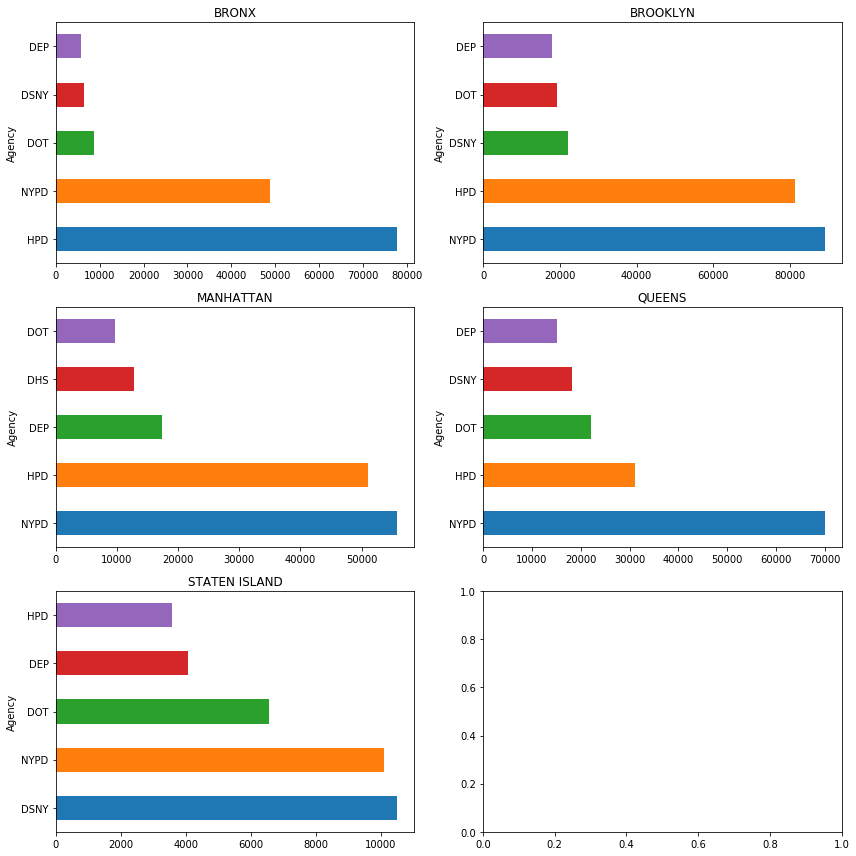

In [6]:
#We'll arrange the subplots in two rows and three columns. 
#Since we have only 5 boroughs, one plot will be blank
%matplotlib inline
COL_NUM = 2
ROW_NUM = 3
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(12,12))

for i, (borough, agency_count) in enumerate(agency_borough.items()): 
    ax = axes[int(i/COL_NUM), i%COL_NUM]
    agency_count = agency_count.sort_values(ascending=False)[:5] 
    agency_count.plot(kind='barh', ax=ax)
    ax.set_title(borough)

plt.tight_layout() 

<h1>Processing time</h1>
<li>We can compute simple statistics on processing time

In [ ]:
grouped = df[['processing_time','Borough']].groupby('Borough')

In [ ]:
grouped.describe()

<h3>But it is easier to convert the timedelta processing_time into floats for calculation purposes</h3>
<li>numpy uses a datetime64 datatype for times</li>
<li>pandas uses its own timestamping format</li>

In [ ]:
print(type(df['Created Date'].iloc[0]))
print(type(df['processing_time'].iloc[0]))

<h4>Converting a pandas timedelta to float</h4>
<li>Since our time is in days, we'll divide each processing time by 1 Day and return a float version of the time

In [ ]:
import numpy as np
#The time it takes to process. Cleaned up
df['float_time'] =df['processing_time'].apply(lambda x:x/np.timedelta64(1, 'D'))

In [ ]:
df

<h2>Group the data and compute statistics</h2>

In [ ]:
grouped = df[['float_time','Agency']].groupby('Agency')
grouped.mean().sort_values('float_time',ascending=False)

In [ ]:
df['float_time'].hist(bins=50)

<h2>Visualizing distributions</h2>
<li>Count incidents by time buckets
<li>Graph it
<li>Overlay a distribution curve

<h2>Try this!</h2>
<li>Create a new column 'hour of day' that buckets Created Date into 0..23
<li>Then group the data by hour of day
<li>Plot the size of the data by hour of day
<li>Plot the mean processing time of the data by hour of day
<li>Are there any hourly differences?

<h4>Create a new "hour of day" column</h4>

In [ ]:
df['hour of day'] = 
#plot size by hour of day


In [ ]:
#plot average by hour of day

<h2>Seaborn</h2>
<li>A library for visualizing statistical functions
<li>https://seaborn.pydata.org

In [ ]:
import seaborn as sns
sns.distplot(df['hour of day'])

<h4>Looks like our "complaints" day runs from 5 am to 5am</h4>
<li>Let's move the data by 5
<li>And we'll superimpose a gamma (normal) curve on the data

In [ ]:
from scipy import stats
sns.distplot(df['hour of day'].apply(lambda x: x if x>3 else x+24),kde=True,fit=stats.gamma)

<h1>Other useful visualization libraries</h1>
<h2>seaborn: https://seaborn.pydata.org/</h2>
<h2>bokeh: http://bokeh.pydata.org/en/latest/</h2>
<h2>plotly: https://plot.ly/</h2>
